In [61]:
import pandas as pd
import numpy as np
import random as rnd
import scipy as sp
from sksurv.util import Surv
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sksurv.ensemble import RandomSurvivalForest
random_state_seed = 97
from sklearn.ensemble import RandomForestRegressor

In [62]:
def datapreprocessing(Xdata, Ydata):

    x_train = pd.read_csv(Xdata, compression='gzip', na_values='isnan')
    x_train['TimetillPrepay'] = pd.to_datetime(x_train.last_pymnt_d) - pd.to_datetime(x_train.issue_d)
    x_train['TimetillPrepay'] = round(x_train['TimetillPrepay']/np.timedelta64(1,'Y'), 2)

    y_train = pd. read_csv(Ydata, compression='gzip', na_values='isnan')

    x_three_yr = x_train.loc[x_train.term==36,:]
    y_three_yr = y_train

    x_five_yr = x_train.loc[x_train.term==60, :]
    y_five_yr = y_train


    X_threeyears = x_three_yr[["id", "term","int_rate","installment","dti","earliest_cr_line",
                             "pub_rec_bankruptcies","log_annual_inc","fico_score", "TimetillPrepay" ]]
    
    #X_threeyears['survival_time'] = X_threeyears['survival_time']/12
    X_fiveyears = x_five_yr[["id", "term","int_rate","installment","dti","earliest_cr_line",
                             "pub_rec_bankruptcies","log_annual_inc","fico_score", "TimetillPrepay" ]]
    
    #X_fiveyears['survival_time'] = X_fiveyears['survival_time']/12
    
    Y_threeyears = y_three_yr[["id", "default", "prepaid",  "survival_time"]]
    Y_threeyears['survival_time'] = Y_threeyears['survival_time']/12
    Y_fiveyears = y_five_yr[["id", "default", "prepaid", "survival_time"]]
    Y_fiveyears['survival_time'] = Y_fiveyears['survival_time']/12
    
    df_3yrs = pd.merge(X_threeyears, Y_threeyears, how="inner", on=["id"])
    df_5yrs = pd.merge(X_fiveyears, Y_fiveyears, how="inner", on=["id"])
    rsf_3yrdata = df_3yrs.loc[:, ["int_rate", "dti", "log_annual_inc", "fico_score", "default", "prepaid", "survival_time", "TimetillPrepay"]]
    rsf_5yrdata = df_5yrs.loc[:, ["int_rate", "dti", "log_annual_inc", "fico_score", "default", "prepaid", "survival_time", "TimetillPrepay"]]

    return rsf_3yrdata, rsf_5yrdata



In [63]:
rsf_3yrdata, rsf_5yrdata = datapreprocessing('C:/Users/ali.kazmane/Desktop/X_train.csv','C:/Users/ali.kazmane/Desktop/y_train.csv')

<ipython-input-62-bec7070a39b9>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_threeyears['survival_time'] = Y_threeyears['survival_time']/12
<ipython-input-62-bec7070a39b9>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_fiveyears['survival_time'] = Y_fiveyears['survival_time']/12


In [64]:
def datapreprocessing_test(Xtestdata, Ytestdata):
    X_test = pd.read_csv(Xtestdata, compression='gzip', na_values='isnan')
    Y_test= pd.read_csv(Ytestdata, compression='gzip', na_values='isnan')
    X_test['TimetillPrepay'] = pd.to_datetime(X_test.last_pymnt_d) - pd.to_datetime(X_test.issue_d)
    X_test['TimetillPrepay'] = round(X_test['TimetillPrepay']/np.timedelta64(1,'Y'), 2)
    Y_test['TimetillPrepay'] = X_test['TimetillPrepay']
    X_test = X_test.drop("TimetillPrepay", axis = 1)
    
    x_three_yr_test = X_test.loc[X_test.term==36,:]
    x_five_yr_test = X_test.loc[X_test.term==60, :]
        
    
    Y_test['survival_time'] = Y_test['survival_time']/12
    rsf_test_3yr = x_three_yr_test.loc[:,["int_rate", "dti", "log_annual_inc", "fico_score"]]
    rsf_test_5yr = x_five_yr_test.loc[:,["int_rate", "dti", "log_annual_inc", "fico_score"]]
    
    return X_test, Y_test, x_three_yr_test, x_five_yr_test, rsf_test_3yr, rsf_test_5yr

In [65]:
X_test, Y_test, x_three_yr_test, x_five_yr_test, rsf_test_3yr, rsf_test_5yr = datapreprocessing_test("C:/Users/ali.kazmane/Desktop/X_test.csv", "C:/Users/ali.kazmane/Desktop/y_test.csv")

In [66]:
from sksurv.util import Surv
def RSF(defaultdata, testdata,dff,df):
    default_data = defaultdata.drop(['prepaid','TimetillPrepay'], axis = 1)
    STRu = defaultdata[ ['survival_time', 'default']]
    YYYY =  Surv.from_dataframe("default", "survival_time", STRu)
    default_data = default_data.drop(["default","survival_time"] , axis = 1)
    rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state_seed)
    rsf.fit(default_data.iloc[0:100,:], YYYY[0:100])
    hazard_pred = rsf.predict_cumulative_hazard_function(testdata.iloc[0:100,:])
    hazard_pred= pd.DataFrame(hazard_pred)
    individual_surv = (pd.DataFrame(rsf.predict_survival_function(dff)).T).iloc[[-1], :]
    weights = df[['funded_amnt']]/df[['funded_amnt']].sum()
    loan_weighted_surv = individual_surv.multiply(weights.T.values)
    aggregate_survival = loan_weighted_surv.sum().sum()
    aggregate_default = 1 - aggregate_survival
    individual_surv.index = ['Terminal Survival Probability']
    individual_surv = individual_surv.T
    individual_surv['Terminal Event Probability'] = 1 - individual_surv['Terminal Survival Probability']
    FinalResult = [aggregate_survival, aggregate_default]
    FinalResult = pd.DataFrame(FinalResult).T
    FinalResult.columns = ["Agg Survival", "Agg Event"]
    print(individual_surv)
    print(FinalResult) 
    
    
    (hazard_pred.T).plot()
    return(hazard_pred, rsf)

C:\ProgramData\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:459: FutureWarning: predict_cumulative_hazard_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(


    Terminal Survival Probability  Terminal Event Probability
0                        0.830582                    0.169418
1                        0.816975                    0.183025
2                        0.786281                    0.213719
3                        0.820071                    0.179929
4                        0.729890                    0.270110
..                            ...                         ...
95                       0.793571                    0.206429
96                       0.730257                    0.269743
97                       0.795314                    0.204686
98                       0.835747                    0.164253
99                       0.926973                    0.073027

[100 rows x 2 columns]
   Agg Survival  Agg Event
0      0.786691   0.213309


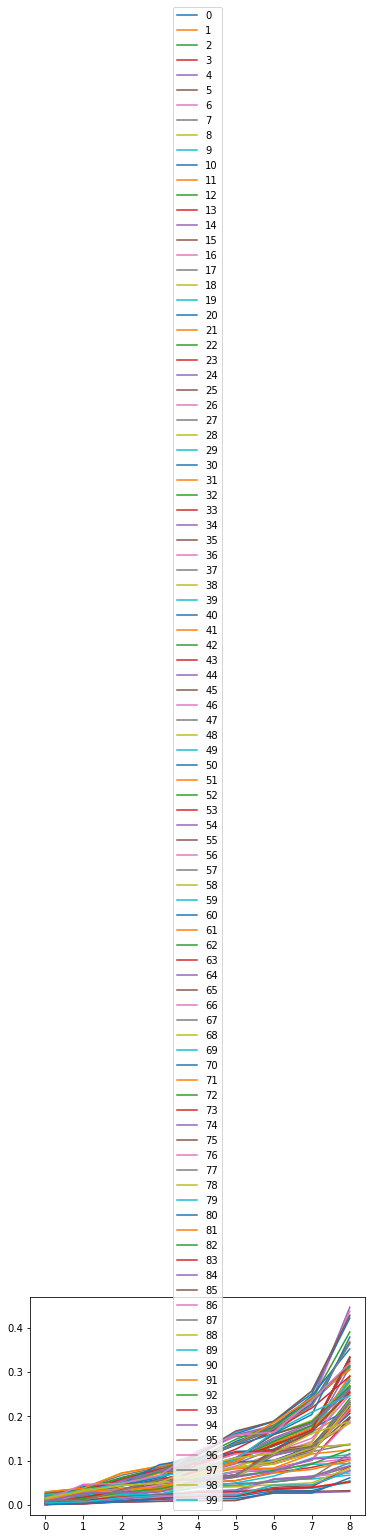

In [67]:
HazardRate_3yr, rsfmodel_3yr = RSF(rsf_3yrdata, rsf_test_3yr, rsf_test_3yr.iloc[:100,:],x_three_yr_test.iloc[:100,:])

C:\ProgramData\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:459: FutureWarning: predict_cumulative_hazard_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sksurv\ensemble\forest.py:527: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(


    Terminal Survival Probability  Terminal Event Probability
0                        0.733662                    0.266338
1                        0.647577                    0.352423
2                        0.882343                    0.117657
3                        0.655732                    0.344268
4                        0.630378                    0.369622
..                            ...                         ...
95                       0.702791                    0.297209
96                       0.735720                    0.264280
97                       0.666500                    0.333500
98                       0.660355                    0.339645
99                       0.694452                    0.305548

[100 rows x 2 columns]
   Agg Survival  Agg Event
0      0.734312   0.265688


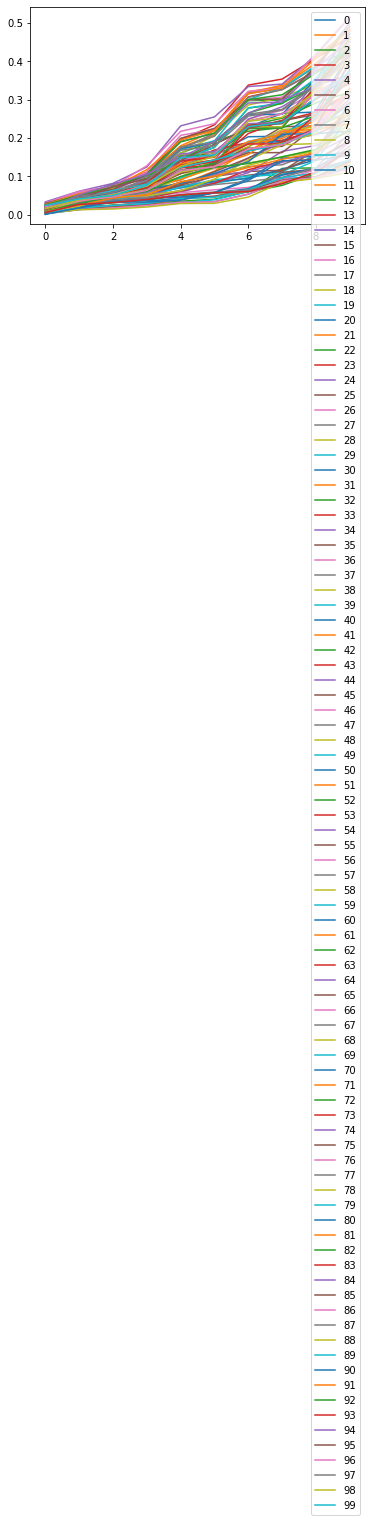

In [68]:
  HazardRate_5yr, rsfmodel_5yr = RSF(rsf_5yrdata, rsf_test_5yr, rsf_test_5yr.iloc[:100,:],x_five_yr_test.iloc[:100,:])